In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

In [2]:
def smape(a, b):
    s = pd.Series(2*abs(a-b)/(abs(a)+abs(b))).fillna(0)
    return 100*s.sum()/len(s)

In [3]:
clinical_data = pd.read_csv('../data/train_clinical_data.csv')
clinical_data.set_index('visit_id', inplace=True)
npx_features = pd.read_csv('../processed_data/proteins_features.csv').set_index('visit_id')

In [4]:
c = clinical_data.dropna().groupby('patient_id').count()[['visit_month']]
c

,visit_month
patient_id,
55,10
942,3
1517,10
3636,10
3863,8
...,...
62792,9
63889,9
64669,12


In [5]:
n = npx_features.groupby('patient_id').count()[['visit_month']]

In [6]:
li = []
for idx, v in enumerate(clinical_data.index.values):
    parts = v.split('_')
    if parts[1] == '0':
        li.append('00000')
    else:
        li.append(clinical_data.index.values[idx-1])

def offset_updrs2(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_2']

def offset_updrs1(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_1']

def offset_updrs3(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_3']

def offset_updrs4(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_4']

clinical_data['offset'] = li

clinical_data['offset_updrs2_offset'] = clinical_data.apply(
    offset_updrs2, axis=1)
clinical_data['offset_updrs1_offset'] = clinical_data.apply(
    offset_updrs1, axis=1)
clinical_data['offset_updrs3_offset'] = clinical_data.apply(
    offset_updrs3, axis=1)
clinical_data['offset_updrs4_offset'] = clinical_data.apply(
    offset_updrs4, axis=1)





clinical_data.fillna(0, inplace=True)


In [7]:
clinical_data = clinical_data[[
    'updrs_1', 'updrs_2', 'offset_updrs2_offset', 'offset_updrs1_offset','offset_updrs3_offset','offset_updrs4_offset', 'updrs_3', 'updrs_4', 'visit_month', 'patient_id']]


In [8]:
t = c.join(n,lsuffix='_c', rsuffix='_n')
t[t['visit_month_c']==t['visit_month_n']]

,visit_month_c,visit_month_n
patient_id,,
18183,9,9
19088,6,6
24690,3,3
27468,8,8
29313,5,5
31270,4,4
52119,2,2
64674,6,6


In [9]:
#sns.pairplot(clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4','offset_updrs1_offset', 'offset_updrs2_offset', 'offset_updrs3_offset', 'offset_updrs4_offset','visit_month']])


In [10]:
patient_visits = []
for vi in clinical_data.index:
    if vi.startswith('40200') or vi.startswith('27468') or vi.startswith('23391'):
        patient_visits.append(vi)
clinical_data_holdout = clinical_data[clinical_data.index.isin(patient_visits)]
clinical_data_train = clinical_data[~clinical_data.index.isin(patient_visits)]
clinical_data_holdout

,updrs_1,updrs_2,offset_updrs2_offset,offset_updrs1_offset,offset_updrs3_offset,offset_updrs4_offset,updrs_3,updrs_4,visit_month,patient_id
visit_id,,,,,,,,,,
23391_0,0.0,3.0,0.0,0.0,0,0.0,6,0.0,0,23391
23391_3,1.0,4.0,3.0,0.0,6,0.0,19,0.0,3,23391
23391_6,2.0,4.0,4.0,1.0,19,0.0,58,0.0,6,23391
23391_9,2.0,6.0,4.0,2.0,58,0.0,17,0.0,9,23391
23391_12,4.0,5.0,6.0,2.0,17,0.0,2,0.0,12,23391
23391_18,4.0,6.0,5.0,4.0,2,0.0,7,0.0,18,23391
23391_24,4.0,7.0,6.0,4.0,7,0.0,16,0.0,24,23391
23391_30,5.0,7.0,7.0,4.0,16,0.0,21,0.0,30,23391
23391_36,6.0,7.0,7.0,5.0,21,0.0,9,0.0,36,23391


# UPDRS 1 Predictions with just protein data

In [11]:
dataset = pd.merge(clinical_data_train[['updrs_1', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[6:]].values
X_noscale = dataset[dataset.columns[1:6]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))

s = setup(data=final_X, target=Y)
add_metric('SMAPE', 'SMAPE', smape, greater_is_better = False)
b1 = create_model('et')
t1 = tune_model(b1, choose_better=True, optimize='SMAPE')
ensemble_u1 = ensemble_model(t1, choose_better= True, n_estimators=20,method='Boosting')



,Description,Value
0,Session id,5597
1,Target,target
2,Target type,Regression
3,Original data shape,"(1047, 235)"
4,Transformed data shape,"(1047, 235)"
5,Transformed train set shape,"(732, 235)"
6,Transformed test set shape,"(315, 235)"
7,Numeric features,234
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,3.0954,16.0217,4.0027,0.4470,0.6256,0.7975,61.3100
1,2.0699,7.7146,2.7775,0.6601,0.5199,0.5347,46.5653
2,2.6015,12.2183,3.4955,0.6571,0.4950,0.5346,46.4948
3,2.6370,14.0089,3.7428,0.4643,0.5632,0.7103,52.0997
4,2.6971,12.5559,3.5434,0.4742,0.6518,0.9844,59.3582
5,2.4730,10.8286,3.2907,0.6270,0.5892,0.5716,53.5641
6,2.7421,12.8090,3.5790,0.5524,0.6498,0.7454,60.2849
7,2.0725,8.7264,2.9540,0.7396,0.5046,0.3986,42.9123
8,2.5404,9.9943,3.1614,0.6125,0.5062,0.6224,45.0658


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,3.1629,17.5933,4.1944,0.3927,0.6409,0.7579,64.9219
1,1.9677,7.3461,2.7104,0.6763,0.5431,0.4873,46.5516
2,2.6929,13.2543,3.6406,0.6280,0.4999,0.4962,47.4530
3,2.5962,13.8326,3.7192,0.4710,0.5621,0.6819,52.2211
4,2.6047,12.3966,3.5209,0.4809,0.6318,0.8953,57.1597
5,2.5273,10.5646,3.2503,0.6360,0.5879,0.5912,55.3868
6,2.6550,12.9968,3.6051,0.5458,0.6644,0.6651,60.2813
7,2.1350,9.1743,3.0289,0.7262,0.5079,0.3914,44.7149
8,2.4336,9.3595,3.0593,0.6371,0.4808,0.5450,44.1198


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,3.2085,16.3920,4.0487,0.4342,0.6609,0.9231,65.9575
1,2.2053,7.9106,2.8126,0.6514,0.5897,0.6146,49.8593
2,2.6364,11.8302,3.4395,0.6680,0.5219,0.5358,46.7434
3,2.7438,14.3004,3.7816,0.4532,0.6020,0.8203,54.2314
4,2.7458,12.5027,3.5359,0.4764,0.6683,1.0152,59.7003
5,2.5797,10.4306,3.2296,0.6407,0.6303,0.6971,55.3701
6,2.8226,12.9993,3.6055,0.5457,0.7091,0.7905,61.8698
7,2.2030,9.4104,3.0676,0.7192,0.5615,0.4731,46.1942
8,2.5368,9.7984,3.1302,0.6201,0.5201,0.6498,45.4628


Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


In [12]:
predict_model(b1)
predict_model(t1)
predict_model(ensemble_u1)
finalize_model(ensemble_u1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2.2361,9.2379,3.0394,0.6439,0.5285,0.6583,48.3763


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2.2361,9.2379,3.0394,0.6439,0.5285,0.6583,48.3763


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2.2361,9.2379,3.0394,0.6439,0.5285,0.6583,48.3763


Pipeline(memory=FastMemory(location=C:\Users\prith\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['feature_1', 'feature_2',
                                             'feature_3', 'feature_4',
                                             'feature_5', 'feature_6',
                                             'feature_7', 'feature_8',
                                             'feature_9', 'feature_10',
                                             'feature_11', 'feature_12',
                                             'feature_13', 'feature_14',
                                             'feature_15', 'feature_16',
                                             'feature_17', 'fea...
                                             'feature_19', 'feature_20',
                                             'feature_21', 'feature_22',
                                             'feature_23', 'feature_24',
                                             'feature_25', 'feature_26',
                                             'feature_27', 'feature_28',
                                             'feature_29', 'feature_30', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator',
                 ExtraTreesRegressor(n_jobs=-1, random_state=5597))])

# UPDRS 2 Predictions with just Protein Data

In [13]:
dataset = pd.merge(clinical_data_train[['updrs_2', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[6:]].values
X_noscale = dataset[dataset.columns[1:6]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))

s = setup(data=final_X, target=Y)
add_metric('SMAPE', 'SMAPE', smape, greater_is_better = False)
b2 = create_model('et')
t2 = tune_model(b2, choose_better=True, optimize='SMAPE')
ensemble_u2 = ensemble_model(t2, choose_better= True, n_estimators=20,method='Boosting')



,Description,Value
0,Session id,4350
1,Target,target
2,Target type,Regression
3,Original data shape,"(1047, 235)"
4,Transformed data shape,"(1047, 235)"
5,Transformed train set shape,"(732, 235)"
6,Transformed test set shape,"(315, 235)"
7,Numeric features,234
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,2.1728,8.3400,2.8879,0.7383,0.6216,0.5153,82.3297
1,2.1980,11.9131,3.4515,0.6706,0.7638,0.4986,91.4793
2,2.3996,11.2053,3.3474,0.7124,0.6138,0.6924,85.4547
3,2.4033,10.8463,3.2934,0.6065,0.6284,0.5604,78.9644
4,2.5562,12.7411,3.5695,0.6757,0.7050,0.8831,94.7960
5,2.7192,13.4031,3.6610,0.6271,0.6394,0.5507,85.6433
6,2.2278,10.2845,3.2070,0.6423,0.6027,0.6207,75.3185
7,1.8282,6.7561,2.5992,0.8075,0.4270,0.4498,81.5777
8,2.4492,12.7253,3.5672,0.7394,0.5191,0.5300,68.2006


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,2.1715,8.2885,2.8790,0.7399,0.6452,0.4561,77.3723
1,2.2090,9.8870,3.1444,0.7266,0.7378,0.4937,91.9422
2,2.3592,10.8221,3.2897,0.7222,0.6408,0.5853,78.0634
3,2.5918,11.1839,3.3442,0.5942,0.6622,0.5560,79.8231
4,2.4902,12.2851,3.5050,0.6873,0.7401,0.7689,88.3986
5,2.6749,13.3083,3.6481,0.6297,0.6619,0.5081,80.7748
6,2.2903,8.9903,2.9984,0.6873,0.6332,0.5390,75.4658
7,2.1658,7.6867,2.7725,0.7810,0.6018,0.4817,81.5664
8,2.7333,15.2333,3.9030,0.6881,0.5883,0.4995,67.4565


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,2.2501,8.6878,2.9475,0.7274,0.7384,0.4425,75.6133
1,2.7049,12.2398,3.4985,0.6615,0.9259,0.5871,92.9019
2,2.9788,13.0663,3.6147,0.6646,0.8603,0.7848,83.1692
3,2.7420,10.9417,3.3078,0.6030,0.7658,0.5902,76.6801
4,2.7458,12.6783,3.5607,0.6773,0.8372,0.8067,88.7642
5,2.8383,13.4247,3.6640,0.6265,0.7421,0.5358,79.0338
6,2.6586,11.3268,3.3655,0.6060,0.8016,0.6315,75.5150
7,2.6148,9.1811,3.0300,0.7385,0.8343,0.5249,81.4771
8,2.9796,15.1008,3.8860,0.6908,0.7035,0.5865,67.5533


Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


In [14]:
predict_model(b2)
predict_model(t2)
predict_model(ensemble_u2)
finalize_model(ensemble_u2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2.2543,9.9189,3.1494,0.7102,0.6573,0.5158,84.0014


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2.3281,9.9262,3.1506,0.7100,0.6819,0.4535,84.4329


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2.3281,9.9262,3.1506,0.7100,0.6819,0.4535,84.4329


Pipeline(memory=FastMemory(location=C:\Users\prith\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['feature_1', 'feature_2',
                                             'feature_3', 'feature_4',
                                             'feature_5', 'feature_6',
                                             'feature_7', 'feature_8',
                                             'feature_9', 'feature_10',
                                             'feature_11', 'feature_12',
                                             'feature_13', 'feature_14',
                                             'feature_15', 'feature_16',
                                             'feature_17', 'fea...
                                             'feature_29', 'feature_30', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator',
                 ExtraTreesRegressor(bootstrap=True, max_depth=4,
                                     min_impurity_decrease=0.0005,
                                     min_samples_leaf=3, min_samples_split=5,
                                     n_estimators=30, n_jobs=-1,
                                     random_state=4350))])

# UPDRS 3 Predictions with Proteins Data

In [15]:
dataset = pd.merge(clinical_data_train[['updrs_3', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[6:]].values
X_noscale = dataset[dataset.columns[1:6]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))

s = setup(data=final_X, target=Y)
add_metric('SMAPE', 'SMAPE', smape, greater_is_better = False)
b3 = create_model('et')
t3 = tune_model(b3, choose_better=True, optimize='SMAPE')
ensemble_u3 = ensemble_model(t3, choose_better= True, n_estimators=20,method='Boosting')



,Description,Value
0,Session id,7050
1,Target,target
2,Target type,Regression
3,Original data shape,"(1047, 235)"
4,Transformed data shape,"(1047, 235)"
5,Transformed train set shape,"(732, 235)"
6,Transformed test set shape,"(315, 235)"
7,Numeric features,234
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,0.4166,2.8177,1.6786,0.9934,0.3332,0.0309,15.9021
1,0.2631,0.5625,0.7500,0.9986,0.1130,0.0629,4.8346
2,0.5374,0.8693,0.9324,0.9974,0.3280,0.0690,26.8993
3,0.5626,4.1042,2.0259,0.9871,0.4737,0.0288,29.3939
4,1.1432,27.7781,5.2705,0.9319,0.3969,0.0663,19.6261
5,0.4047,1.0506,1.0250,0.9977,0.2172,0.0448,11.7563
6,1.9127,64.4337,8.0271,0.8757,0.4325,0.0538,11.9860
7,0.7219,3.0194,1.7376,0.9923,0.3941,0.1249,26.1619
8,0.8581,9.0486,3.0081,0.9769,0.5310,0.0262,18.5613


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,0.3280,4.2554,2.0629,0.9901,0.3423,0.0132,14.6722
1,0.2948,0.6712,0.8193,0.9983,0.1036,0.0599,4.8399
2,0.2515,0.5377,0.7333,0.9984,0.2999,0.0176,17.9005
3,0.7693,10.8986,3.3013,0.9656,0.5142,0.0226,29.0818
4,1.0096,37.3102,6.1082,0.9085,0.4184,0.0205,11.0708
5,0.4012,1.3619,1.1670,0.9970,0.2256,0.0639,14.0589
6,1.7470,67.9880,8.2455,0.8689,0.4284,0.0516,15.0521
7,0.4934,3.0643,1.7505,0.9922,0.2481,0.0339,22.4406
8,0.3809,2.7903,1.6704,0.9929,0.3306,0.0173,17.7580


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,3.1919,16.5896,4.0730,0.9614,0.6294,0.4627,44.3853
1,2.9814,14.9018,3.8603,0.9618,0.4149,0.5536,33.9739
2,3.0575,13.0401,3.6111,0.9606,0.6843,0.5107,51.9528
3,3.1074,17.9758,4.2398,0.9433,0.8607,0.3837,61.3232
4,3.8467,39.5840,6.2916,0.9029,0.6652,0.5504,52.0987
5,3.4982,17.2711,4.1559,0.9625,0.5772,0.5257,44.4918
6,4.4456,68.7649,8.2925,0.8674,0.6298,0.4706,47.8732
7,2.7378,12.2460,3.4994,0.9688,0.6377,0.4409,47.9188
8,3.2332,21.6720,4.6553,0.9446,0.7376,0.2916,43.6864


Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


In [16]:
predict_model(b3)
predict_model(t3)
predict_model(ensemble_u3)
finalize_model(ensemble_u3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,0.8558,19.0727,4.3672,0.9539,0.4343,0.0790,17.7302


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,0.7279,18.9434,4.3524,0.9542,0.4494,0.0236,16.6275


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,0.7279,18.9434,4.3524,0.9542,0.4494,0.0236,16.6275


Pipeline(memory=FastMemory(location=C:\Users\prith\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['feature_1', 'feature_2',
                                             'feature_3', 'feature_4',
                                             'feature_5', 'feature_6',
                                             'feature_7', 'feature_8',
                                             'feature_9', 'feature_10',
                                             'feature_11', 'feature_12',
                                             'feature_13', 'feature_14',
                                             'feature_15', 'feature_16',
                                             'feature_17', 'fea...
                                             'feature_27', 'feature_28',
                                             'feature_29', 'feature_30', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator',
                 ExtraTreesRegressor(criterion='absolute_error', max_depth=9,
                                     min_impurity_decrease=0.0001,
                                     min_samples_leaf=3, n_estimators=260,
                                     n_jobs=-1, random_state=7050))])

# UPDRS 4 Predictions with Proteins Data

In [17]:
dataset = pd.merge(clinical_data_train[['updrs_4', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[6:]].values
X_noscale = dataset[dataset.columns[1:6]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))

s = setup(data=final_X, target=Y)
add_metric('SMAPE', 'SMAPE', smape, greater_is_better = False)
b4 = create_model('et')
t4 = tune_model(b4, choose_better=True, optimize='SMAPE')
ensemble_u4 = ensemble_model(t4, choose_better= True, n_estimators=20, method='Boosting')



,Description,Value
0,Session id,7109
1,Target,target
2,Target type,Regression
3,Original data shape,"(1047, 235)"
4,Transformed data shape,"(1047, 235)"
5,Transformed train set shape,"(732, 235)"
6,Transformed test set shape,"(315, 235)"
7,Numeric features,234
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,0.9595,4.0526,2.0131,0.6132,0.5156,0.4870,162.2561
1,0.8986,1.8870,1.3737,0.6192,0.5649,0.4019,158.1691
2,0.9616,2.7226,1.6500,0.6014,0.6016,0.4977,162.4711
3,1.0395,2.9477,1.7169,-0.0257,0.5919,0.9023,150.9868
4,0.9153,2.1300,1.4595,0.7141,0.5335,0.4429,157.5491
5,0.6840,1.4402,1.2001,0.6707,0.4954,0.5322,171.1591
6,0.8616,1.9488,1.3960,0.4243,0.4892,0.6628,168.6644
7,1.0085,2.7401,1.6553,0.5613,0.6030,0.6176,170.6011
8,1.0229,3.7015,1.9239,0.4307,0.5626,0.7987,167.5427


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,1.1892,11.8919,3.4485,-0.1350,0.8220,1.0000,40.5405
1,1.1351,6.2432,2.4986,-0.2601,0.8435,1.0000,48.6486
2,1.1370,8.1233,2.8501,-0.1893,0.8291,1.0000,43.8356
3,0.9452,3.7671,1.9409,-0.3109,0.7712,1.0000,57.5342
4,1.2055,8.9041,2.9840,-0.1950,0.8502,1.0000,46.5753
5,0.6164,4.7534,2.1802,-0.0869,0.6012,1.0000,27.3973
6,0.8904,4.1781,2.0440,-0.2342,0.7513,1.0000,43.8356
7,0.9726,7.1918,2.6817,-0.1515,0.7652,1.0000,35.6164
8,1.0685,7.6438,2.7647,-0.1756,0.7977,1.0000,46.5753


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,1.1892,11.8919,3.4485,-0.1350,0.8220,1.0000,40.5405
1,1.1351,6.2432,2.4986,-0.2601,0.8435,1.0000,48.6486
2,1.1370,8.1233,2.8501,-0.1893,0.8291,1.0000,43.8356
3,0.9452,3.7671,1.9409,-0.3109,0.7712,1.0000,57.5342
4,1.2055,8.9041,2.9840,-0.1950,0.8502,1.0000,46.5753
5,0.6164,4.7534,2.1802,-0.0869,0.6012,1.0000,27.3973
6,0.8904,4.1781,2.0440,-0.2342,0.7513,1.0000,43.8356
7,0.9726,7.1918,2.6817,-0.1515,0.7652,1.0000,35.6164
8,1.0685,7.6438,2.7647,-0.1756,0.7977,1.0000,46.5753


Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


In [18]:
predict_model(b4)
predict_model(t4)
predict_model(ensemble_u4)
finalize_model(ensemble_u4)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,0.9343,3.1397,1.7719,0.3424,0.5520,0.6837,165.3778


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,0.9016,5.5873,2.3637,-0.1703,0.7452,1.0000,37.4603


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,0.9016,5.5873,2.3637,-0.1703,0.7452,1.0000,37.4603


Pipeline(memory=FastMemory(location=C:\Users\prith\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['feature_1', 'feature_2',
                                             'feature_3', 'feature_4',
                                             'feature_5', 'feature_6',
                                             'feature_7', 'feature_8',
                                             'feature_9', 'feature_10',
                                             'feature_11', 'feature_12',
                                             'feature_13', 'feature_14',
                                             'feature_15', 'feature_16',
                                             'feature_17', 'fea...
                                             'feature_29', 'feature_30', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator',
                 ExtraTreesRegressor(criterion='absolute_error', max_depth=5,
                                     max_features='sqrt',
                                     min_impurity_decrease=0.5,
                                     min_samples_leaf=3, n_estimators=20,
                                     n_jobs=-1, random_state=7109))])

In [19]:
ensemble_u1

ExtraTreesRegressor(n_jobs=-1, random_state=5597)

In [20]:
updrs1_test = pd.merge(clinical_data_holdout[['updrs_1', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
Y_test = updrs1_test[updrs1_test.columns[0]].values
X_test = updrs1_test[updrs1_test.columns[6:]].values
X_noscale_test = updrs1_test[updrs1_test.columns[1:6]].values
X_scaled_test = StandardScaler().fit(X).transform(X_test)
final_X_test = np.hstack((X_noscale, X_scaled))

y_predict = predict_model(ensemble_u1, data=pd.DataFrame(final_X_test, columns=[f'feature_{i+1}' for i in range(final_X_test.shape[1])]))['prediction_label']
updrs1_test.reset_index(inplace=True)
updrs1_test['prediction'] = y_predict
plot1 = updrs1_test[['visit_id', 'updrs_1', 'prediction']]
plot1

,visit_id,updrs_1,prediction
0,23391_0,0.0,5.23
1,23391_6,2.0,8.00
2,23391_12,4.0,10.00
3,23391_24,4.0,17.00
4,23391_36,6.0,8.00
5,23391_48,5.0,5.00
6,23391_60,4.0,2.00
7,23391_72,8.0,2.00
8,23391_84,11.0,11.00
9,27468_0,9.0,18.82


In [21]:
updrs2_test = pd.merge(clinical_data_holdout[['updrs_2', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
Y_test = updrs2_test[updrs2_test.columns[0]].values
X_test = updrs2_test[updrs2_test.columns[6:]].values
X_noscale_test = updrs2_test[updrs2_test.columns[1:6]].values
X_scaled_test = StandardScaler().fit(X).transform(X_test)
final_X_test = np.hstack((X_noscale, X_scaled))

y_predict = predict_model(ensemble_u2, data=pd.DataFrame(final_X_test, columns=[f'feature_{i+1}' for i in range(final_X_test.shape[1])]))['prediction_label']
updrs2_test.reset_index(inplace=True)
updrs2_test['prediction'] = y_predict
plot2 = updrs2_test[['visit_id', 'updrs_2', 'prediction']]
plot2

,visit_id,updrs_2,prediction
0,23391_0,3.0,2.929650
1,23391_6,4.0,7.703273
2,23391_12,5.0,8.585667
3,23391_24,7.0,13.017826
4,23391_36,7.0,2.921820
5,23391_48,6.0,2.720842
6,23391_60,5.0,5.569220
7,23391_72,6.0,3.784492
8,23391_84,15.0,2.915067
9,27468_0,8.0,12.941766


In [22]:
updrs3_test = pd.merge(clinical_data_holdout[['updrs_3', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
Y_test = updrs3_test[updrs3_test.columns[0]].values
X_test = updrs3_test[updrs3_test.columns[6:]].values
X_noscale_test = updrs3_test[updrs3_test.columns[1:6]].values
X_scaled_test = StandardScaler().fit(X).transform(X_test)
final_X_test = np.hstack((X_noscale, X_scaled))

y_predict = predict_model(ensemble_u3, data=pd.DataFrame(final_X_test, columns=[f'feature_{i+1}' for i in range(final_X_test.shape[1])]))['prediction_label']
updrs3_test.reset_index(inplace=True)
updrs3_test['prediction'] = y_predict
plot3 = updrs3_test[['visit_id', 'updrs_3', 'prediction']]
plot3

,visit_id,updrs_3,prediction
0,23391_0,6,6.000000
1,23391_6,58,58.000000
2,23391_12,2,2.000000
3,23391_24,16,9.000000
4,23391_36,9,58.000000
5,23391_48,51,2.000000
6,23391_60,0,16.000000
7,23391_72,58,51.000000
8,23391_84,0,6.000000
9,27468_0,6,16.000000


In [23]:
updrs4_test = pd.merge(clinical_data_holdout[['updrs_4', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
Y_test = updrs4_test[updrs4_test.columns[0]].values
X_test = updrs4_test[updrs4_test.columns[6:]].values
X_noscale_test = updrs4_test[updrs4_test.columns[1:6]].values
X_scaled_test = StandardScaler().fit(X).transform(X_test)
final_X_test = np.hstack((X_noscale, X_scaled))

y_predict = predict_model(ensemble_u4, data=pd.DataFrame(final_X_test, columns=[f'feature_{i+1}' for i in range(final_X_test.shape[1])]))['prediction_label']
updrs4_test.reset_index(inplace=True)
updrs4_test['prediction'] = y_predict
plot4 = updrs4_test[['visit_id', 'updrs_4', 'prediction']]
plot4

,visit_id,updrs_4,prediction
0,23391_0,0.0,0.0
1,23391_6,0.0,0.0
2,23391_12,0.0,0.0
3,23391_24,0.0,0.0
4,23391_36,0.0,0.0
5,23391_48,0.0,0.0
6,23391_60,0.0,0.0
7,23391_72,1.0,0.0
8,23391_84,0.0,0.0
9,27468_0,0.0,0.0


In [24]:
plot1['patient'] = plot1['visit_id'].apply(lambda x: x.split('_')[0])
plot2['patient'] = plot2['visit_id'].apply(lambda x: x.split('_')[0])
plot3['patient'] = plot3['visit_id'].apply(lambda x: x.split('_')[0])
plot4['patient'] = plot4['visit_id'].apply(lambda x: x.split('_')[0])
plot1['month'] = plot1['visit_id'].apply(lambda x: int(x.split('_')[1]))
plot2['month'] = plot2['visit_id'].apply(lambda x: int(x.split('_')[1]))
plot3['month'] = plot3['visit_id'].apply(lambda x: int(x.split('_')[1]))
plot4['month'] = plot4['visit_id'].apply(lambda x: int(x.split('_')[1]))

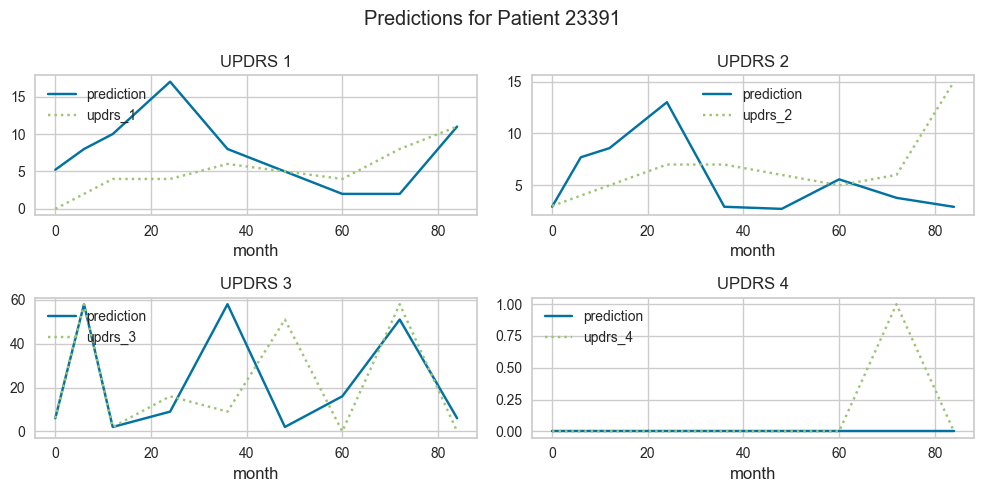

In [25]:
import matplotlib.pyplot as plt

pid='23391'
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,5))
plot1[plot1['patient']==pid].plot.line(x='month',y='prediction',ax=ax1)
plot1[plot1['patient']==pid].plot.line(x='month',y='updrs_1',ax=ax1,ls=":")
plot2[plot2['patient']==pid].plot.line(x='month',y='prediction',ax=ax2)
plot2[plot2['patient']==pid].plot.line(x='month',y='updrs_2',ax=ax2, ls=':')
plot3[plot3['patient']==pid].plot.line(x='month',y='prediction',ax=ax3)
plot3[plot3['patient']==pid].plot.line(x='month',y='updrs_3',ax=ax3, ls=':')
plot4[plot4['patient']==pid].plot.line(x='month',y='prediction',ax=ax4)
plot4[plot4['patient']==pid].plot.line(x='month',y='updrs_4',ax=ax4, ls=':')
plt.suptitle(f'Predictions for Patient {pid}')
ax1.set_title('UPDRS 1')
ax2.set_title('UPDRS 2')
ax3.set_title('UPDRS 3')
ax4.set_title('UPDRS 4')
fig.tight_layout()

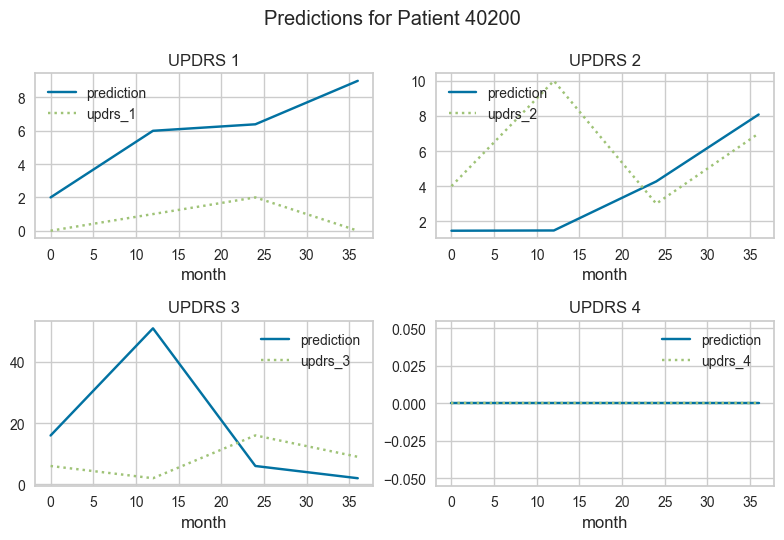

In [26]:
import matplotlib.pyplot as plt

pid='40200'
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
plot1[plot1['patient']==pid].plot.line(x='month',y='prediction',ax=ax1)
plot1[plot1['patient']==pid].plot.line(x='month',y='updrs_1',ax=ax1,ls=":")
plot2[plot2['patient']==pid].plot.line(x='month',y='prediction',ax=ax2)
plot2[plot2['patient']==pid].plot.line(x='month',y='updrs_2',ax=ax2, ls=':')
plot3[plot3['patient']==pid].plot.line(x='month',y='prediction',ax=ax3)
plot3[plot3['patient']==pid].plot.line(x='month',y='updrs_3',ax=ax3, ls=':')
plot4[plot4['patient']==pid].plot.line(x='month',y='prediction',ax=ax4)
plot4[plot4['patient']==pid].plot.line(x='month',y='updrs_4',ax=ax4, ls=':')
plt.suptitle(f'Predictions for Patient {pid}')
ax1.set_title('UPDRS 1')
ax2.set_title('UPDRS 2')
ax3.set_title('UPDRS 3')
ax4.set_title('UPDRS 4')
fig.tight_layout()


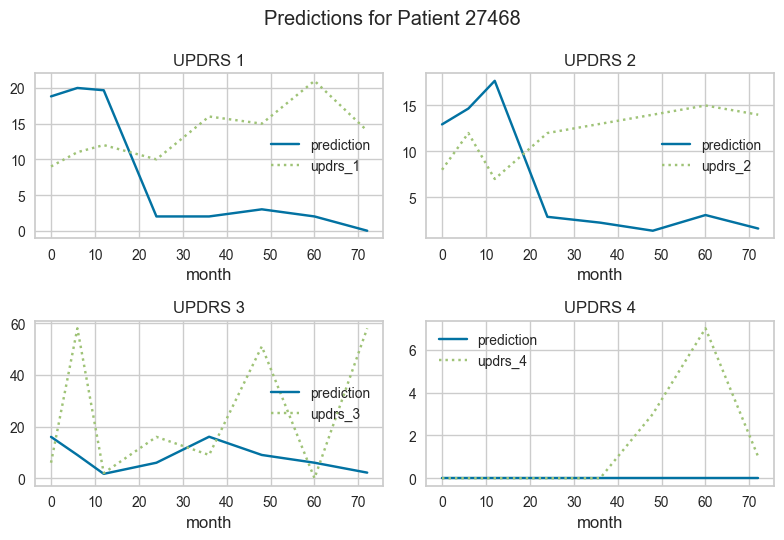

In [28]:
import matplotlib.pyplot as plt

pid='27468'
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
plot1[plot1['patient']==pid].plot.line(x='month',y='prediction',ax=ax1)
plot1[plot1['patient']==pid].plot.line(x='month',y='updrs_1',ax=ax1,ls=":")
plot2[plot2['patient']==pid].plot.line(x='month',y='prediction',ax=ax2)
plot2[plot2['patient']==pid].plot.line(x='month',y='updrs_2',ax=ax2, ls=':')
plot3[plot3['patient']==pid].plot.line(x='month',y='prediction',ax=ax3)
plot3[plot3['patient']==pid].plot.line(x='month',y='updrs_3',ax=ax3, ls=':')
plot4[plot4['patient']==pid].plot.line(x='month',y='prediction',ax=ax4)
plot4[plot4['patient']==pid].plot.line(x='month',y='updrs_4',ax=ax4, ls=':')
plt.suptitle(f'Predictions for Patient {pid}')
ax1.set_title('UPDRS 1')
ax2.set_title('UPDRS 2')
ax3.set_title('UPDRS 3')
ax4.set_title('UPDRS 4')
fig.tight_layout()